In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from admm import run_admm
%load_ext pyinstrument

# autoreload for debugging
%load_ext autoreload
%autoreload 2

In [68]:
m = 50_000
np.random.seed(0)

d = 1000
P = np.random.randn(10, d)
P = P.T @ P
P = P / np.max(np.abs(P))
P = P + np.eye(d) * np.random.rand(d) * .1
q = np.random.randn(d) * .2 - .1

# C = np.array(
#     [[1.0, -0.5, 0.3],
#      [-0.5, 1.0, 0.2],
#      [0.3, 0.2, 1.0]]

# )
# sd = np.array([0.1, 0.2, 0.3])
# P = np.diag(sd) @ C @ np.diag(sd)
# q = -np.array([0.1, 0.14, 0.21])
# d = 3

# sample m samples from a d-dimensional Gaussian with covariance P and mean q
A = np.random.multivariate_normal(q, P, m)

# P = np.eye(d)
# q = -np.ones(d)
# A = np.zeros((m,d))


beta = .1
kappa = .009

k = int(beta * m)
alpha = kappa * k

A_box = np.eye(d)
A_total = np.ones((1, d))


gamma = .05

def box_prox(z):
    return np.clip(z, 0, lim)

def total_prox(z):
    return np.clip(z, 0, 1)

proj_As = [A_box, A_total]
proj_fns = [box_prox, total_prox]

lim = 1
def gen_constraints(x):
    return [
        0 <= cp.sum(x), cp.sum(x) <= 1,
        0 <= x, x <= lim,
    ]

def gen_objective(x):
    return cp.Minimize(.5 * cp.quad_form(x, gamma*P) + q @ x)

In [56]:
# compute the conditional value at risk .1 of a normal distribution with mean
# np.sum(q) and variance np.ones(3).T @ P @ np.ones(3)
variance = np.ones(3).T @ P @ np.ones(3) / 3**2
mean = np.mean(q)
# let phi be the standard normal pdf
phi = lambda x: np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
# let Phi_inv be the standard normal cdf inverse
from scipy.stats import norm
Phi_inv = norm.ppf
-mean + np.sqrt(variance) * phi(Phi_inv(beta)) / beta

0.3854557200833176

In [57]:
q.max(), q.min(), kappa, A.max(), A.min()

(-0.1, -0.21, 0.009, 1.060793065913175, -1.4730787847195432)

In [69]:
# solve the problem with cvxpy for reference
x_cvxpy = cp.Variable(d)
objective = gen_objective(x_cvxpy)
constraints = gen_constraints(x_cvxpy)
constraints += [
    cp.sum_largest(A@x_cvxpy, k) <= alpha ,
]
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK, verbose=True)
print(prob.value)
# print the sum of the largest k elements of A @ x_cvxpy.value
print(np.sort(A @ x_cvxpy.value)[::-1][:k].sum() / m, kappa)

                                     CVXPY                                     
                                     v1.4.3                                    
(CVXPY) Apr 25 02:28:06 PM: Your problem has 1000 variables, 5 constraints, and 0 parameters.
(CVXPY) Apr 25 02:28:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 25 02:28:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 25 02:28:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 25 02:28:07 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 25 02:28:07 PM: Compiling problem (target solver=MOSEK).
(

In [70]:
x_cvxpy.value.min()

-1.5020921794088456e-09

In [99]:
# warm start with fewer scenarios
m_ = 1000
A_ = A[:m_]
k_ = int(beta * m_)
alpha_ = kappa * k_
x_cvxpy_ = cp.Variable(d)

objective = gen_objective(x_cvxpy_)
constraints = gen_constraints(x_cvxpy_)
constraints += [
    cp.sum_largest(A_@x_cvxpy_, k_) <= alpha_ , 
]
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK)
print(prob.value)
print(np.sort(A_ @ x_cvxpy_.value)[::-1][:k].sum() / m_, kappa)

-0.7801721174433367
-0.7768616660462433 0.009


In [104]:
# %%pyinstrument

x, history = run_admm(
     gamma*P, q, A, beta, kappa, proj_As, proj_fns, max_iter=10_000, alpha_over=1.7, rho=.7, warm=x, #warm=x_cvxpy_.value
)

print(history["objval"][-1])
print(np.sort(A @ x)[::-1][:k].sum())

print("relative objective error: ", abs(history["objval"][-1] - prob.value) / abs(prob.value))

iter: 0, objval: -20.58925446478448, r_norm: 1.344178477868236, s_norm: 11.888118751859706, u_norm: 1.3441721876737462, time: 1.0072908401489258
iter: 100, objval: -20.565613375495857, r_norm: 1.3391722719208208, s_norm: 135.4273590330283, u_norm: 228.22791221327827, time: 2.867189884185791
iter: 200, objval: -20.458023662605306, r_norm: 1.3384540890255738, s_norm: 238.02635528189165, u_norm: 567.9032944702922, time: 5.041773080825806
iter: 300, objval: -20.22648010646772, r_norm: 1.3455111687593264, s_norm: 297.02625229078956, u_norm: 1075.0410417408755, time: 7.364076852798462
iter: 400, objval: -19.811825488338116, r_norm: 1.3647391010584071, s_norm: 336.6565377684042, u_norm: 1831.540682602498, time: 9.766985893249512
iter: 500, objval: -19.121150512468073, r_norm: 1.4333051208082803, s_norm: 366.0638054244379, u_norm: 2959.0950044319075, time: 12.188750982284546
iter: 600, objval: -18.01725296928229, r_norm: 1.6125108630351996, s_norm: 380.8290663283196, u_norm: 4638.875427732669,

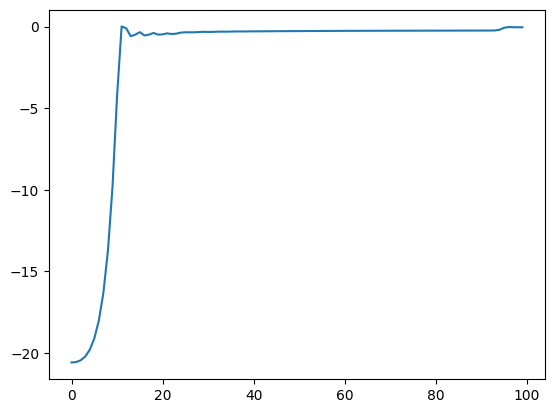

In [105]:
plt.plot(history["objval"])

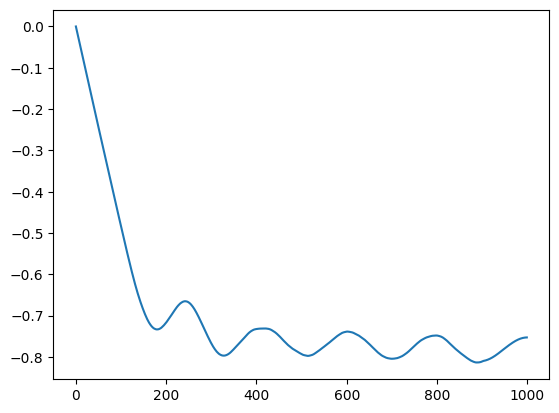

In [98]:
# plt.plot(history["objval"]) # 100k .7 rho

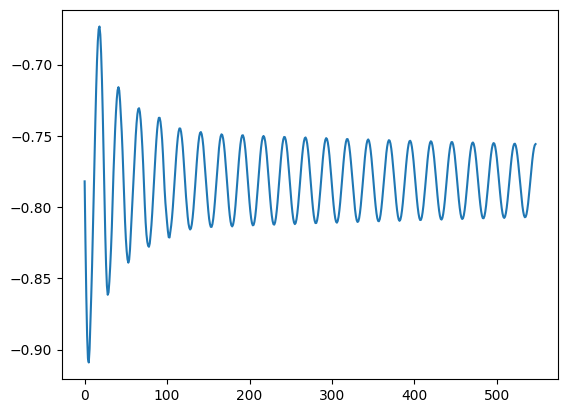

In [28]:
plt.plot(history["objval"])

In [29]:
x.min(), x.max(), x.sum()

(3.5003923824707657e-06, 0.6899582105336116, 0.9999587147572031)

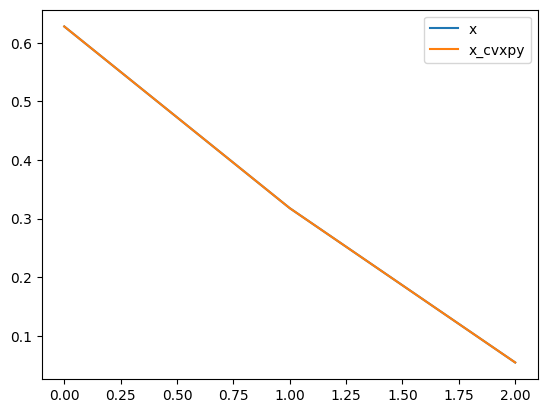

In [52]:
plt.plot(x, label="x")
plt.plot(x_cvxpy.value, label="x_cvxpy")
plt.legend()